# Particle Swarm Optimisation for the Travelling Salesman Problem

Particle Swarm Optimisation (PSO) is a population-based metaheuristic inspired by collective behaviour in biological swarms. In classical PSO, particles move through a continuous search space by combining three influences: inertia (keep moving), cognition (return toward personal best), and social learning (move toward the global best).

The Travelling Salesman Problem (TSP) is a combinatorial optimisation problem: the solution is a permutation of cities rather than a continuous vector. To apply PSO to TSP, we need a discrete representation and a discrete notion of “movement”.

In this notebook, we implement a **permutation-based PSO** for TSP. The focus is on clarity and a research-friendly structure consistent with the ACO and Firefly notebooks: clean data handling, explicit algorithm setup, baseline training, optional local refinement, and interpretable visualisations.


# Particle Swarm Optimisation for the Travelling Salesman Problem

Particle Swarm Optimisation (PSO) is a population-based metaheuristic inspired by collective behaviour in biological swarms. In classical PSO, particles move through a continuous search space by combining three influences: inertia (keep moving), cognition (return toward personal best), and social learning (move toward the global best).

The Travelling Salesman Problem (TSP) is a combinatorial optimisation problem: the solution is a permutation of cities rather than a continuous vector. To apply PSO to TSP, we need a discrete representation and a discrete notion of “movement”.

In this notebook, we implement a **permutation-based PSO** for TSP. The focus is on clarity and a research-friendly structure consistent with the ACO and Firefly notebooks: clean data handling, explicit algorithm setup, baseline training, optional local refinement, and interpretable visualisations.


In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\david\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\david\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\david\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\david\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\david\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\david\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



## Data Loading and Problem Representation

We load two data sources:

- A **travel-time (distance) matrix** that defines the optimisation objective.  
  This is the matrix PSO will minimise.

- A **coordinate file** containing latitude/longitude for each city.  
  Coordinates are used strictly for visualisation and sanity checks.

A key requirement is **consistent city ordering** across the matrix, coordinates, and tours. We enforce this by reordering the coordinate rows to match the matrix column order.


In [3]:
# -----------------------------
# Load distance matrix (optimisation)
# -----------------------------
cities_matrix = pd.read_csv(
    "../data/macedonia_travel_time_matrix_all_cities_only.csv",
    index_col=0
)

# -----------------------------
# Load coordinates (visualisation)
# -----------------------------
cities_cords = pd.read_csv("../data/mk.csv")

# Clean column names (handles BOM / trailing spaces)
cities_cords.columns = cities_cords.columns.str.replace("\ufeff", "", regex=False).str.strip()

# Keep only needed columns
cities_cords = cities_cords[["city", "lat", "lng"]].copy()

# Filter to cities in the matrix
cities_cords = cities_cords[cities_cords["city"].isin(cities_matrix.columns)].copy()

# Reorder rows to match matrix order (CRITICAL)
cities_cords = cities_cords.set_index("city").loc[cities_matrix.columns].reset_index()

cities_cords = cities_cords.rename(columns={"index": "city"})


# Final objects used downstream
distance_matrix = cities_matrix.values
n_cities = distance_matrix.shape[0]
city_names = cities_cords["city"].tolist()

# For plotting: x=lng, y=lat
cities = cities_cords[["lng", "lat"]].values

# Sanity checks
assert len(city_names) == n_cities
assert cities.shape[0] == n_cities


## Visual Sanity Check

Before running any optimisation, it is useful to confirm that the set of cities is correct and that coordinates are plotted in the correct orientation:

- x-axis: longitude (`lng`)
- y-axis: latitude (`lat`)

We annotate each point with its city name for interpretability.


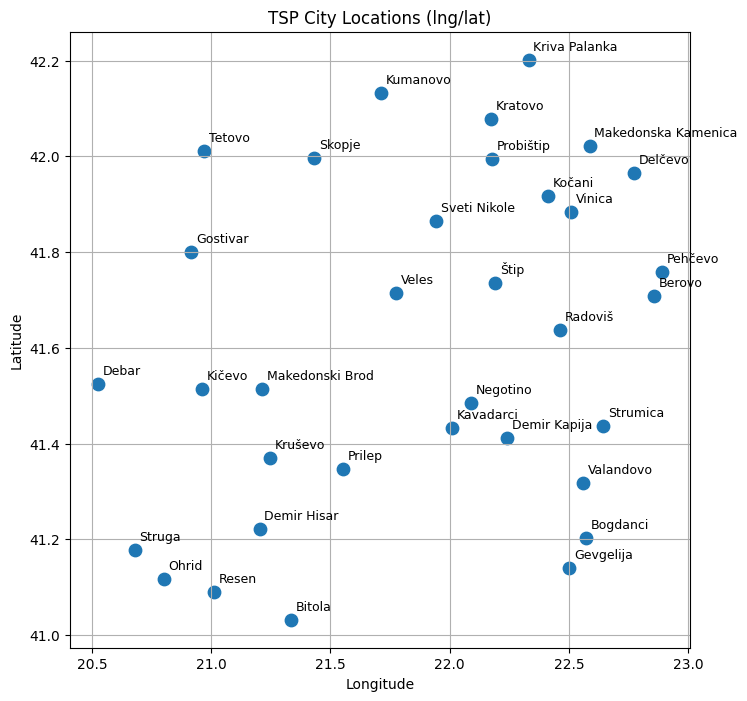

In [4]:
plt.figure(figsize=(8, 8))
plt.scatter(cities_cords["lng"], cities_cords["lat"], s=80)

for _, row in cities_cords.iterrows():
    plt.text(row["lng"] + 0.02, row["lat"] + 0.02, row["city"], fontsize=9)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("TSP City Locations (lng/lat)")
plt.grid(True)
plt.show()


## Tour Utilities

A TSP tour is represented as a list of city indices. The objective is to minimise total tour length using the travel-time matrix.

We define:
- a tour-length function
- a tour plotting function consistent with the city map (lng/lat + names)


In [5]:
def tour_length(tour, distance_matrix):
    length = 0.0
    for i in range(len(tour)):
        length += distance_matrix[tour[i], tour[(i + 1) % len(tour)]]
    return length


def plot_tour(coords, tour, city_names, title="Tour"):
    closed_tour = tour + [tour[0]]
    ordered_coords = coords[closed_tour]
    ordered_names = [city_names[i] for i in closed_tour]

    plt.figure(figsize=(8, 8))
    plt.plot(
        ordered_coords[:, 0],  # lng
        ordered_coords[:, 1],  # lat
        "-o",
        linewidth=2,
        markersize=6
    )

    for (x, y), name in zip(ordered_coords, ordered_names):
        plt.text(x + 0.02, y + 0.02, name, fontsize=9)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.grid(True)
    plt.show()


## PSO for TSP: Discrete Representation

In continuous PSO, a particle has a position and a velocity. For TSP, the position is a permutation (a tour), and velocity must be replaced by a discrete operator.

We use a simple, common adaptation:

- A particle’s position is a tour.
- To “move” toward a target tour (personal best or global best), we compute a **swap sequence** that transforms the current tour into the target.
- We then apply a **subset** of those swaps, controlled probabilistically.

This preserves PSO’s main intuition:
- inertia: keep part of the current structure
- cognition: learn from the particle’s best tour
- social: learn from the swarm’s best tour


In [6]:
def random_tour(n):
    tour = list(range(n))
    random.shuffle(tour)
    return tour


def get_swaps(current, target):
    """
    Compute a sequence of swaps that transforms 'current' into 'target'.
    This is used as a discrete analogue of 'velocity'.
    """
    swaps = []
    temp = current.copy()
    pos = {city: i for i, city in enumerate(temp)}

    for i in range(len(temp)):
        if temp[i] != target[i]:
            j = pos[target[i]]
            swaps.append((i, j))

            # apply swap in temp and update positions
            pos[temp[i]] = j
            pos[target[i]] = i
            temp[i], temp[j] = temp[j], temp[i]

    return swaps


def apply_swaps(tour, swaps, prob):
    """
    Apply each swap with probability 'prob'.
    """
    out = tour.copy()
    for (i, j) in swaps:
        if random.random() < prob:
            out[i], out[j] = out[j], out[i]
    return out


## PSO Parameters

We keep parameterisation deliberately simple and notebook-friendly:

- `w` controls inertia (how strongly particles keep their current structure)
- `c1` controls cognitive influence (movement toward personal best)
- `c2` controls social influence (movement toward global best)

In this discrete setting, `c1` and `c2` are mapped to probabilities of applying swaps that move toward the corresponding target tour.


In [7]:
n_particles = n_cities
n_iterations = 200

w = 0.6    # inertia strength (used to scale how much we keep vs change)
c1 = 1.5   # cognitive
c2 = 1.5   # social

# Convert to probabilities (simple, interpretable mapping)
def clip_prob(x, lo=0.0, hi=1.0):
    return max(lo, min(hi, x))

p_cognitive = clip_prob(c1 / (c1 + c2 + 1e-12))
p_social    = clip_prob(c2 / (c1 + c2 + 1e-12))

# Global step size factor controlling how aggressively swaps are applied
base_swap_prob = 0.35


## Swarm Initialisation

Particles are initialised with random tours. Each particle stores:

- its current tour (position)
- its personal best tour
- its personal best length

The swarm also tracks the global best tour found so far.


In [8]:
particles = [random_tour(n_cities) for _ in range(n_particles)]

personal_best = [p.copy() for p in particles]
personal_best_lengths = [tour_length(p, distance_matrix) for p in personal_best]

best_idx = int(np.argmin(personal_best_lengths))
global_best = personal_best[best_idx].copy()
global_best_length = personal_best_lengths[best_idx]

global_best_history = [global_best_length]

print("Initial global best length:", global_best_length)


Initial global best length: 3617.9999999999995


## Training the Base PSO Algorithm

Each PSO iteration updates every particle using three influences:

1. **Inertia**  
   Keep some of the current structure (implemented implicitly by not applying all swaps).

2. **Cognitive learning**  
   Move toward the particle’s personal best tour.

3. **Social learning**  
   Move toward the swarm’s global best tour.

After updating, each particle is evaluated. Personal bests and the global best are updated whenever improvements occur.

We track the best-so-far tour length to study convergence.


In [9]:
for it in range(n_iterations):
    for i in range(n_particles):
        current = particles[i]

        # Swap sequences toward personal and global best
        swaps_to_pbest = get_swaps(current, personal_best[i])
        swaps_to_gbest = get_swaps(current, global_best)

        # Inertia: reduce move intensity slightly via w (smaller w -> more change)
        # Here we use w to scale the base probability of applying swaps.
        prob_move = clip_prob(base_swap_prob * (1.0 + (1.0 - w)))

        # Apply cognitive and social moves
        # We apply a subset of swaps from each list
        if swaps_to_pbest:
            current = apply_swaps(current, swaps_to_pbest, prob_move * p_cognitive)
        if swaps_to_gbest:
            current = apply_swaps(current, swaps_to_gbest, prob_move * p_social)

        # Update particle position
        particles[i] = current

        # Evaluate
        curr_len = tour_length(current, distance_matrix)

        # Update personal best
        if curr_len < personal_best_lengths[i]:
            personal_best[i] = current.copy()
            personal_best_lengths[i] = curr_len

            # Update global best
            if curr_len < global_best_length:
                global_best = current.copy()
                global_best_length = curr_len

    global_best_history.append(global_best_length)

    if (it + 1) % 20 == 0:
        print(f"Iteration {it+1:3d} | Global best length: {global_best_length:.4f}")


Iteration  20 | Global best length: 2641.6000
Iteration  40 | Global best length: 2609.9000
Iteration  60 | Global best length: 2609.9000
Iteration  80 | Global best length: 2609.9000
Iteration 100 | Global best length: 2609.9000
Iteration 120 | Global best length: 2609.9000
Iteration 140 | Global best length: 2609.9000
Iteration 160 | Global best length: 2609.9000
Iteration 180 | Global best length: 2609.9000
Iteration 200 | Global best length: 2609.9000


## Convergence Behaviour

We plot the best tour length found so far across iterations. This helps diagnose whether the swarm continues improving or stalls early.


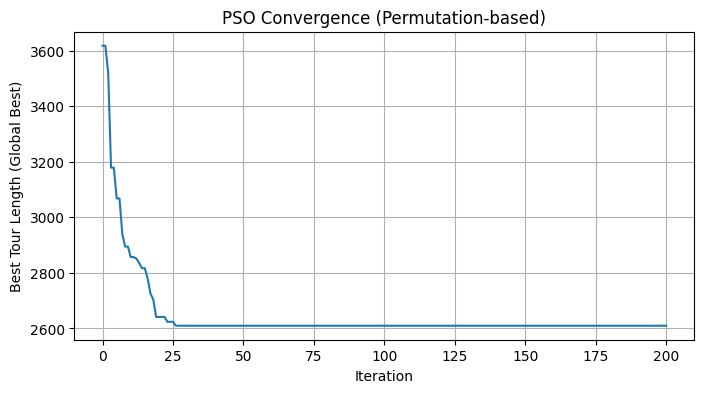

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(global_best_history)
plt.xlabel("Iteration")
plt.ylabel("Best Tour Length (Global Best)")
plt.title("PSO Convergence (Permutation-based)")
plt.grid(True)
plt.show()


## Best Tour Found

Finally, we visualise the best tour found by PSO using the same lng/lat plotting style and city-name annotations used earlier.


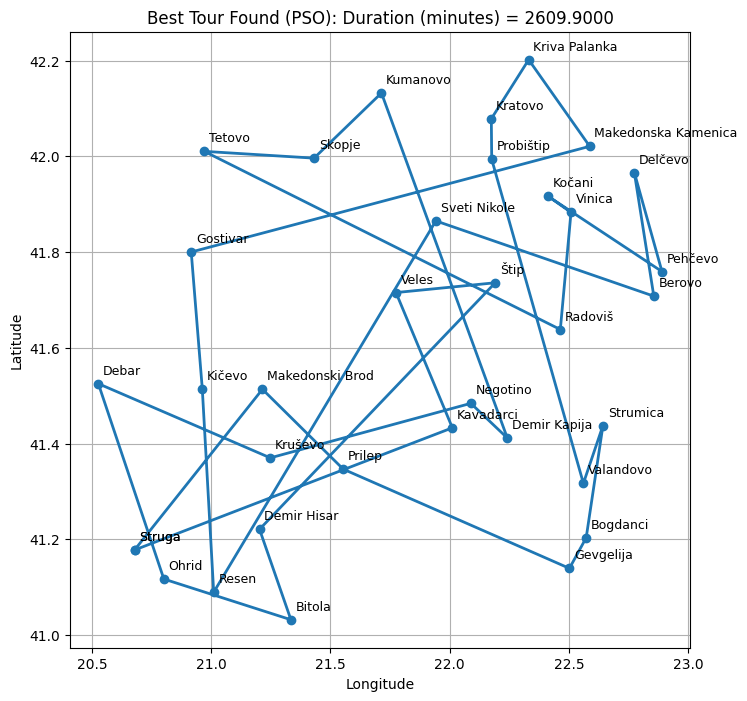

In [13]:
plot_tour(cities, global_best, city_names, title="Best Tour Found (PSO): Duration (minutes) = {:.4f}".format(global_best_length))


## Optional: Local Search Refinement (2-opt)

PSO can produce strong tours, but discrete swarm dynamics may still leave small local inefficiencies. A lightweight 2-opt refinement can be used as a polishing step.

This is optional. If runtime is a concern, keep the improvement cap small.


PSO best length: 2609.8999999999996
Refined length: 1299.3


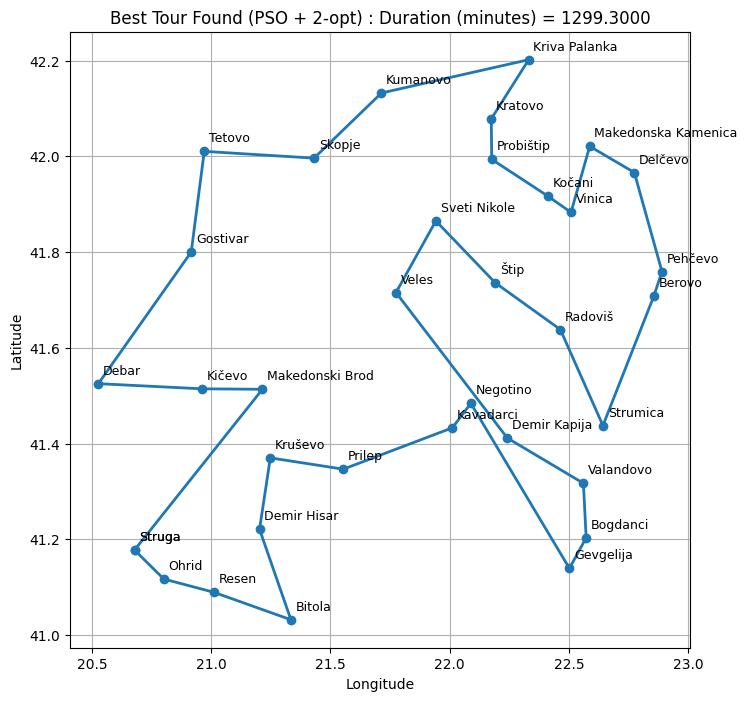

In [14]:
def two_opt(tour, distance_matrix, max_improvements=None):
    best = tour.copy()
    best_len = tour_length(best, distance_matrix)

    improvements = 0
    n = len(best)

    improved = True
    while improved:
        improved = False

        for a in range(1, n - 2):
            for b in range(a + 1, n - 1):
                new = best[:a] + best[a:b+1][::-1] + best[b+1:]
                new_len = tour_length(new, distance_matrix)

                if new_len < best_len:
                    best = new
                    best_len = new_len
                    improved = True
                    improvements += 1

                    if max_improvements is not None and improvements >= max_improvements:
                        return best, best_len

    return best, best_len


refined_best, refined_len = two_opt(global_best, distance_matrix, max_improvements=100)

print("PSO best length:", global_best_length)
print("Refined length:", refined_len)

plot_tour(cities, refined_best, city_names, title="Best Tour Found (PSO + 2-opt) : Duration (minutes) = {:.4f}".format(refined_len))


## Discussion and Notes

This notebook implemented a permutation-based PSO for TSP using swap sequences as a discrete analogue of velocity. The approach preserves PSO’s core principles (memory + social sharing) while respecting the combinatorial structure of the problem.

Practical notes:

- If the swarm stagnates early, slightly increase `base_swap_prob` or decrease `w` to encourage more movement.
- If convergence is unstable, reduce `base_swap_prob` or increase `w`.
- Increasing the number of particles improves exploration but increases runtime.
- A small 2-opt refinement often improves final tour quality at low additional complexity.

This structure is intentionally clean and extensible for comparative studies against ACO, Firefly, and other metaheuristics.
